In [1]:
from IPython.display import HTML
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import flopy
import sys
sys.path.append('../modules')
from scipy.interpolate import griddata

import fonctions_roussillon as fr

In [2]:
delr,delz,K,S,top,grid,extent = fr.read_pickle("../data/cross_section/flopy")
ws = pl.Path('./temp/SWI_pump_ss')
name = 'SWI'
gwfname = 'flow'
gwtname = 'trans'

x0,x1,z0,z1=extent

nlay = len(delz)
ncol = len(delr)
nrow = 1
sl=.6
sealevel=.6
nyears=4
ndays=365*nyears

botm = np.array([top - (i+1)*delz[i] for i in range(len(delz))])

perioddata=[[11700*365*24*3600, 200, 1.]]

nouter, ninner = 200, 100
hclose, rclose, relax = 1e-3, 1e-3, 0.97
delc = 1.0

top=np.reshape(top,(1,len(top)))
botm=np.reshape(botm,(np.shape(botm)[0],1,np.shape(botm)[1]))
grid=flopy.discretization.StructuredGrid(np.array([1]),delr,xoff=x0,yoff=0,top=top,botm=botm)

In [3]:
he=[0.565,1.1,1.278,1.843,2.3]
be=[0.368,0.369,0.611,0.794,0.85]
prof_demmer=np.array([-4,-22,-30,-40,-48,-83,-115,-177,-210,-244,-284,-313])
ghb_amont=np.zeros(np.shape(botm[:,0,0]))
fac=.0002

water_h=be  #On commence par les basses eaux
j=0
for k in range(nlay):
    depth=botm[k,0,0]    
    if len(np.argwhere(prof_demmer>depth))==0:
        ghb=water_h[0]
    else:
        idx=np.max(np.argwhere(prof_demmer>depth))
        if idx<=1:
            ghb=water_h[0]

        if idx==2:
            ghb=water_h[1]-(depth+35)*fac

        if idx==3:
            ghb=water_h[1]-(-40+35)*fac
        if idx==4:
            ghb=water_h[2]-(depth+65)*fac
        if idx==5:
            ghb=water_h[2]-(-83+65)*fac
        if idx==6:
            ghb=water_h[3]-(depth+179)*fac
        if idx==7:
            ghb=water_h[3]-(-177+179)*fac
        if idx==8:
            ghb=water_h[3]-(depth+179)*fac
        if idx==9:
            ghb=water_h[3]-(-244+179)*fac
        if idx==10:
            ghb=water_h[4]-(depth+299)*fac
        if idx==11:
            ghb=water_h[4]-(-313+299)*fac
    ghb_amont[k]=ghb
    

In [4]:
res2=np.copy(ghb_amont)

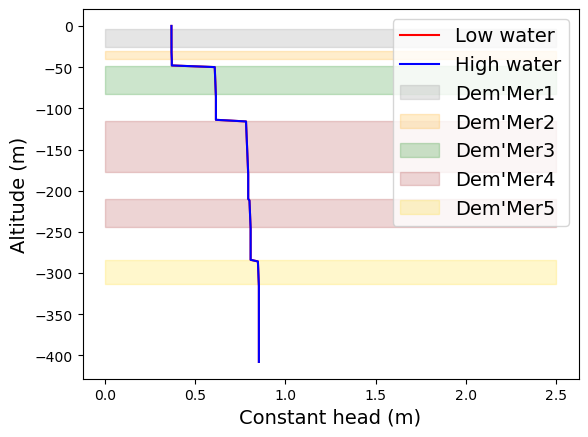

In [5]:
plt.plot(res2,botm[:,0,0],label='Low water',color='red')
plt.plot(ghb_amont,botm[:,0,0],label='High water',color='blue')
plt.ylabel('Altitude (m)',fontsize=14)
plt.xlabel('Constant head (m)',fontsize=14)

plt.fill_between([0,2.5],[-4,-4],[-25,-25], facecolor="grey", edgecolor="grey", linewidth=1.0,alpha=.2,label="Dem'Mer1")
plt.fill_between([0,2.5],[-30,-30],[-40,-40], facecolor="orange", edgecolor="orange", linewidth=1.0,alpha=.2,label="Dem'Mer2")
plt.fill_between([0,2.5],[-48,-48],[-83,-83], facecolor="green", edgecolor="green", linewidth=1.0,alpha=.2,label="Dem'Mer3")
plt.fill_between([0,2.5],[-115,-115],[-177,-177], facecolor="brown", edgecolor="brown", linewidth=1.0,alpha=.2,label="Dem'Mer4")
plt.fill_between([0,2.5],[-210,-210],[-244,-244], facecolor="brown", edgecolor="brown", linewidth=1.0,alpha=.2)
plt.fill_between([0,2.5],[-284,-284],[-313,-313], facecolor="gold", edgecolor="gold", linewidth=1.0,alpha=.2,label="Dem'Mer5")

plt.legend(fontsize=14)
plt.savefig('ghb.png',dpi=300)

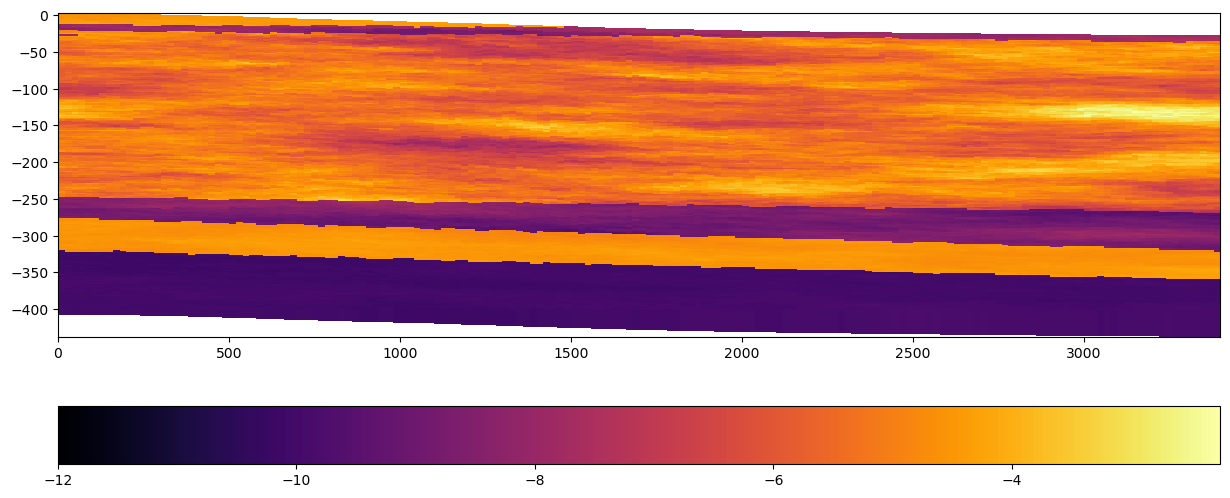

In [30]:
figure, ax = plt.subplots(figsize=(15, 6))

line=[(x0, 0), (x1, 0)]

xc = flopy.plot.PlotCrossSection(modelgrid=grid,line={"line": line})
pc = xc.plot_array(K,cmap='inferno',vmin=-12)
plt.colorbar(pc,location='bottom')

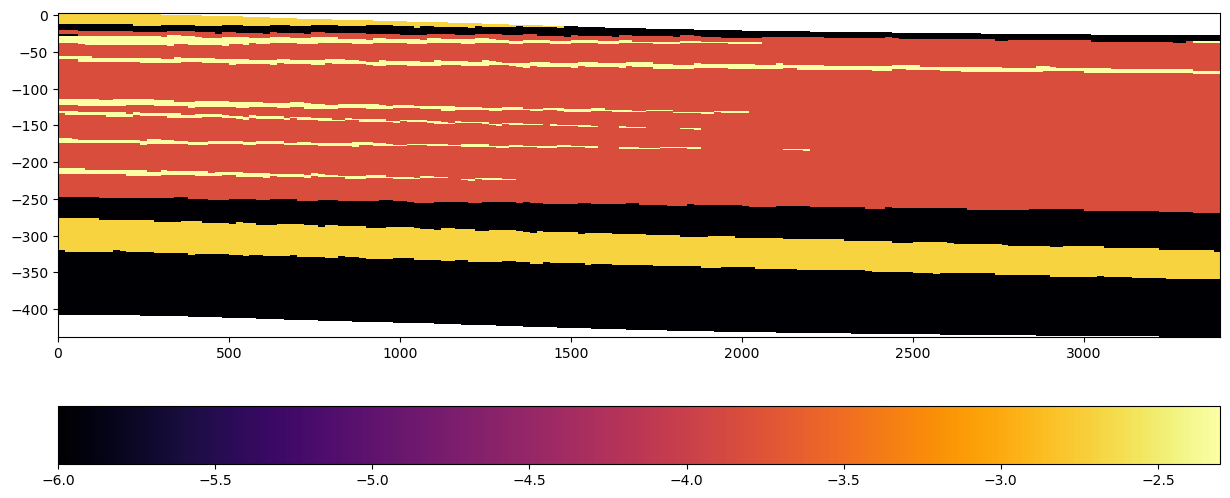

In [31]:
figure, ax = plt.subplots(figsize=(15, 6))

line=[(x0, 0), (x1, 0)]

xc = flopy.plot.PlotCrossSection(modelgrid=grid,line={"line": line})
pc = xc.plot_array(S,cmap='inferno')
plt.colorbar(pc,location='bottom')

In [9]:
idomain=np.full(np.shape(K),1)
idomain=idomain.reshape([np.shape(K)[0],1,np.shape(K)[1]])

In [10]:
Ks=np.reshape(10**K,np.shape(idomain))
Ss=np.reshape(10**S,np.shape(idomain))

In [13]:
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='C:/exe/mf6.exe')
tdis = flopy.mf6.ModflowTdis(
    sim, time_units='SECONDS', perioddata=perioddata
)

gwf = flopy.mf6.ModflowGwf(
    sim, 
    modelname=gwfname,
)

dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol,
    delr=delr, 
    delc=delc,
    top=top, 
    botm=botm,
    idomain=idomain,
)


ic = flopy.mf6.ModflowGwfic(gwf, strt=0)
npf = flopy.mf6.ModflowGwfnpf(
    gwf, 
    xt3doptions=False,
    save_flows=True,
    save_specific_discharge=True,
    icelltype=0,
    k=Ks #in m/s
)

sto = flopy.mf6.ModflowGwfsto(
    gwf, 
    iconvert=1,
    ss=Ss, #specific storage
    steady_state=[False],
    transient=[True]
)

buy = flopy.mf6.ModflowGwfbuy(
    gwf, 
packagedata=[(0, 0.7, 0.0, f"{gwtname}", "none")], #0.7 est la pente de la relation concentration/densité: Pourquoi irhospec=0?
    denseref=1000.0, #density when concentration is 0
)

ghbspd = {}
drnspd = {}
drnlist=[]
ghblist=[]
# drn and ghb
for j in range(ncol):
    zcell = top[0,j]
    cond = Ks[0,0,j] * (delz[0] * delc) / (0.5 * delr[0])
    if zcell > sl:
        drnlist.append([(0, 0, j), zcell, cond, 0.0])
    else:
        ghblist.append([(0, 0, j), sl+(sl-zcell)/40, cond, 35.0, 1024.5])
if len(ghblist) > 0:
    ghbspd[0] = ghblist
if len(drnlist) > 0:
    drnspd[0] = drnlist

ghbspd2={}
ghblist=[]

for k in range(nlay):
    if ghb_amont[k]>botm[k,0,0]:
        ghblist.append([(k, 0, 0), ghb_amont[k], 10**Ks[k,0,0], 0])
ghbspd2[0]=ghblist
    
# drn
drn1 = flopy.mf6.ModflowGwfdrn(
    gwf,
    stress_period_data=drnspd,
    print_input=True,
    print_flows=True,
    save_flows=False,
    pname="DRN-1",
    auxiliary="CONCENTRATION",
)

# ghb
ghb1 = flopy.mf6.ModflowGwfghb(
    gwf,
    stress_period_data=ghbspd,
    print_input=True,
    print_flows=True,
    save_flows=False,
    pname="GHB-1",
    auxiliary=["CONCENTRATION", "DENSITY"],
)

ghb2 = flopy.mf6.ModflowGwfghb(
    gwf,
    stress_period_data=ghbspd2,
    print_input=True,
    print_flows=True,
    save_flows=False,
    pname="GHB-2",
    auxiliary=["CONCENTRATION"],
)

# qspd={}
# qcfx=Fc*xFs
# wellist = []
# for k in range(nlay):
#     wellist.append([(k, 0, 0), qcfx[k], 0.])
# qspd[0]=wellist


# wel = flopy.mf6.ModflowGwfwel(
#     gwf,
#     stress_period_data=qspd,
#     save_flows=False,
#     auxiliary='CONCENTRATION',
#     pname="CFX",
# )

oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=f"{gwfname}.cbc",
    head_filerecord=f"{gwfname}.hds",
    headprintrecord=[
        ('COLUMNS', 10, 'WIDTH', 15,
         'DIGITS', 6, 'GENERAL')],
    saverecord=[('HEAD', 'ALL'),
                ('BUDGET', 'ALL')],
    printrecord=[('HEAD', 'LAST'),
                 ('BUDGET', 'LAST')])

gwt = flopy.mf6.ModflowGwt(sim, modelname=gwtname)
dis = flopy.mf6.ModflowGwtdis(
    gwt, 
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol,
    delr=delr, 
    delc=delc,
    top=top, 
    botm=botm,
    idomain=idomain,
)
ic = flopy.mf6.ModflowGwtic(gwt, strt=0)
adv = flopy.mf6.ModflowGwtadv(gwt, scheme='UPSTREAM')

diffusion_only = False
if diffusion_only:
    diffc = 0.57024/86400
    alh = 0.0
    ath = 0.0
    xt3d = False
else:
    diffc = 0
    alh = 0.1
    ath = 0.01
    xt3d = True
xt3d_off = not xt3d
dsp = flopy.mf6.ModflowGwtdsp(
    gwt, xt3d_off=xt3d_off, diffc=diffc, alh=alh, ath1=ath
)

mst = flopy.mf6.ModflowGwtmst(gwt, porosity=0.35)
sourcerecarray = [
    ("GHB-2", "AUX", "CONCENTRATION"),
    ("GHB-1", "AUX", "CONCENTRATION"),
]
ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
fmi = flopy.mf6.ModflowGwtfmi(gwt, flow_imbalance_correction=True)
oc = flopy.mf6.ModflowGwtoc(
    gwt,
    budget_filerecord=f"{gwtname}.cbc",
    concentration_filerecord=f"{gwtname}.ucn",
    concentrationprintrecord=[
        ('COLUMNS', 10, 'WIDTH', 15,
         'DIGITS', 6, 'GENERAL')],
    saverecord=[('CONCENTRATION', 'ALL')],
    printrecord=[('CONCENTRATION', 'LAST'),
                 ('BUDGET', 'LAST')])
gwfgwt = flopy.mf6.ModflowGwfgwt(
    sim, 
    exgtype='GWF6-GWT6',
    exgmnamea=gwfname, 
    exgmnameb=gwtname,
)

imsgwf = flopy.mf6.ModflowIms(
    sim, 
    print_option='ALL',
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation='NONE',
    inner_maximum=ninner,
    inner_dvclose=hclose, 
    rcloserecord=rclose,
    linear_acceleration='BICGSTAB',
    scaling_method='NONE',
    reordering_method='NONE',
    relaxation_factor=relax,
    filename=f"{gwf.name}.ims",
)
imsgwt = flopy.mf6.ModflowIms(
    sim, 
    print_option='ALL',
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation='NONE',
    inner_maximum=ninner,
    inner_dvclose=hclose, 
    rcloserecord=rclose,
    linear_acceleration='BICGSTAB',
    scaling_method='NONE',
    reordering_method='NONE',
    relaxation_factor=relax,
    filename=f"{gwt.name}.ims",
)
sim.register_ims_package(imsgwf, [gwf.name])
sim.register_ims_package(imsgwt, [gwt.name])



In [14]:
#change geol

K = fr.read_pickle("../data/cross_section/flopy")[2]
Ks=np.reshape(10**K,np.shape(idomain))

npf = flopy.mf6.ModflowGwfnpf(
    gwf, 
    xt3doptions=False,
    save_flows=True,
    save_specific_discharge=True,
    icelltype=1,
    k=Ks #in m/s
)

In [15]:
sim.write_simulation()
sim.run_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing package SWI.gwfgwt...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package sto...
    writing package buy...
INFORMATION: nrhospecies in ('gwf6', 'buy', 'dimensions') changed to 1 based on size of packagedata
    writing package drn-1...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 16 based on size of stress_period_data
    writing package ghb-1...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 154 based on size of stress_period_data
    writing package ghb-2...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 205 based on size of stress_period_data
    writing package oc...
    writing package npf...
  writing model trans...
    writing model name file...
    writing package dis...


    Solving:  Stress period:     1    Time step:   104
    Solving:  Stress period:     1    Time step:   105
    Solving:  Stress period:     1    Time step:   106
    Solving:  Stress period:     1    Time step:   107
    Solving:  Stress period:     1    Time step:   108
    Solving:  Stress period:     1    Time step:   109
    Solving:  Stress period:     1    Time step:   110
    Solving:  Stress period:     1    Time step:   111
    Solving:  Stress period:     1    Time step:   112
    Solving:  Stress period:     1    Time step:   113
    Solving:  Stress period:     1    Time step:   114
    Solving:  Stress period:     1    Time step:   115
    Solving:  Stress period:     1    Time step:   116
    Solving:  Stress period:     1    Time step:   117
    Solving:  Stress period:     1    Time step:   118
    Solving:  Stress period:     1    Time step:   119
    Solving:  Stress period:     1    Time step:   120
    Solving:  Stress period:     1    Time step:   121
    Solvin

(True, [])

In [16]:
it=199
hobj = gwf.output.head()
Heads=hobj.get_alldata()
Heads[np.abs(Heads)>1000]=np.nan

cobj = gwt.output.concentration()
Concs = cobj.get_alldata()

Concs[np.abs(Concs)>1000]=np.nan

bobj=gwf.output.budget()
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
        bobj.get_data(text="DATA-SPDIS")[it],
        gwf,
        )

In [17]:
Qx=qx.reshape(nlay,ncol)
Qz=qz.reshape(nlay,ncol)

grid_x=grid.xcellcenters[0]
grid_z=np.linspace(z0,z1,nlay)

Xx,Zz=np.meshgrid(grid_x,grid_z)

posx=np.ravel(Xx)
posz=np.ravel(grid.zcellcenters[:,0,:])

pos=[(posx[i],posz[i]) for i in range(len(posx))]


Qx_r=griddata(pos, np.ravel(Qx), (Xx,Zz))
Qz_r=griddata(pos, np.ravel(Qz), (Xx,Zz))

In [19]:
fr.write_pickle("../data/cross_section/res_be",[Xx,Zz,Qx_r,Qz_r,Concs[it,:,0,:]])

# Hautes eaux

In [20]:
he=[0.565,1.1,1.278,1.843,2.3]
be=[0.368,0.361,0.611,0.794,0.8]
prof_demmer=np.array([-4,-22,-30,-40,-48,-83,-115,-177,-210,-244,-284,-313])
ghb_amont=np.zeros(np.shape(botm[:,0,0]))
fac=.001

water_h=he
j=0
for k in range(nlay):
    depth=botm[k,0,0]    
    if len(np.argwhere(prof_demmer>depth))==0:
        ghb=water_h[0]
    else:
        idx=np.max(np.argwhere(prof_demmer>depth))
        if idx<=1:
            ghb=water_h[0]

        if idx==2:
            ghb=water_h[1]-(depth+35)*fac

        if idx==3:
            ghb=water_h[1]-(-40+35)*fac
        if idx==4:
            ghb=water_h[2]-(depth+65)*fac
        if idx==5:
            ghb=water_h[2]-(-83+65)*fac
        if idx==6:
            ghb=water_h[3]-(depth+179)*fac
        if idx==7:
            ghb=water_h[3]-(-177+179)*fac
        if idx==8:
            ghb=water_h[3]-(depth+179)*fac
        if idx==9:
            ghb=water_h[3]-(-244+179)*fac
        if idx==10:
            ghb=water_h[4]-(depth+299)*fac
        if idx==11:
            ghb=water_h[4]-(-313+299)*fac
    ghb_amont[k]=ghb
    

ghbspd2={}
ghblist=[]

for k in range(nlay):
    if ghb_amont[k]>botm[k,0,0]:
        ghblist.append([(k, 0, 0), ghb_amont[k], 10**Ks[k,0,0], 0])
ghbspd2[0]=ghblist
    
    
ghb2 = flopy.mf6.ModflowGwfghb(
    gwf,
    stress_period_data=ghbspd2,
    print_input=True,
    print_flows=True,
    save_flows=False,
    pname="GHB-2",
    auxiliary=["CONCENTRATION"],
)


In [21]:
sim.write_simulation()
sim.run_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing package SWI.gwfgwt...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package sto...
    writing package buy...
    writing package drn-1...
    writing package ghb-1...
    writing package oc...
    writing package npf...
    writing package ghb-2...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 205 based on size of stress_period_data
  writing model trans...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package fmi...
    writing package oc...
FloPy is using the following executable to run the model: ..\..\..\..\..\..\..\exe\mf6.exe
                                 

    Solving:  Stress period:     1    Time step:   109
    Solving:  Stress period:     1    Time step:   110
    Solving:  Stress period:     1    Time step:   111
    Solving:  Stress period:     1    Time step:   112
    Solving:  Stress period:     1    Time step:   113
    Solving:  Stress period:     1    Time step:   114
    Solving:  Stress period:     1    Time step:   115
    Solving:  Stress period:     1    Time step:   116
    Solving:  Stress period:     1    Time step:   117
    Solving:  Stress period:     1    Time step:   118
    Solving:  Stress period:     1    Time step:   119
    Solving:  Stress period:     1    Time step:   120
    Solving:  Stress period:     1    Time step:   121
    Solving:  Stress period:     1    Time step:   122
    Solving:  Stress period:     1    Time step:   123
    Solving:  Stress period:     1    Time step:   124
    Solving:  Stress period:     1    Time step:   125
    Solving:  Stress period:     1    Time step:   126
    Solvin

(True, [])

In [22]:
it=199
hobj = gwf.output.head()
Heads=hobj.get_alldata()
Heads[np.abs(Heads)>1000]=np.nan

cobj = gwt.output.concentration()
Concs = cobj.get_alldata()

Concs[np.abs(Concs)>1000]=np.nan

bobj=gwf.output.budget()
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
        bobj.get_data(text="DATA-SPDIS")[it],
        gwf,
        )

In [23]:
Qx=qx.reshape(nlay,ncol)
Qz=qz.reshape(nlay,ncol)

grid_x=grid.xcellcenters[0]
grid_z=np.linspace(z0,z1,nlay)

Xx,Zz=np.meshgrid(grid_x,grid_z)

posx=np.ravel(Xx)
posz=np.ravel(grid.zcellcenters[:,0,:])

pos=[(posx[i],posz[i]) for i in range(len(posx))]


Qx_r=griddata(pos, np.ravel(Qx), (Xx,Zz))
Qz_r=griddata(pos, np.ravel(Qz), (Xx,Zz))

In [24]:
fr.write_pickle("../data/cross_section/res_he",[Xx,Zz,Qx_r,Qz_r,Concs[it,:,0,:]])

# Figure Making

## Hautes Eaux

In [25]:
Xx,Zz,Qx_r,Qz_r,Conc=fr.read_pickle("../data/cross_section/res_he")

In [26]:
grid_x=grid.xcellcenters[0]
grid_z=np.linspace(z0,z1,nlay)

Xx,Zz=np.meshgrid(grid_x,grid_z)

posx=np.ravel(Xx)
posz=np.ravel(grid.zcellcenters[:,0,:])

pos=[(posx[i],posz[i]) for i in range(len(posx))]


Conc_p=griddata(pos, np.ravel(Conc), (Xx,Zz))
Conc_p[Conc_p<1]=np.nan

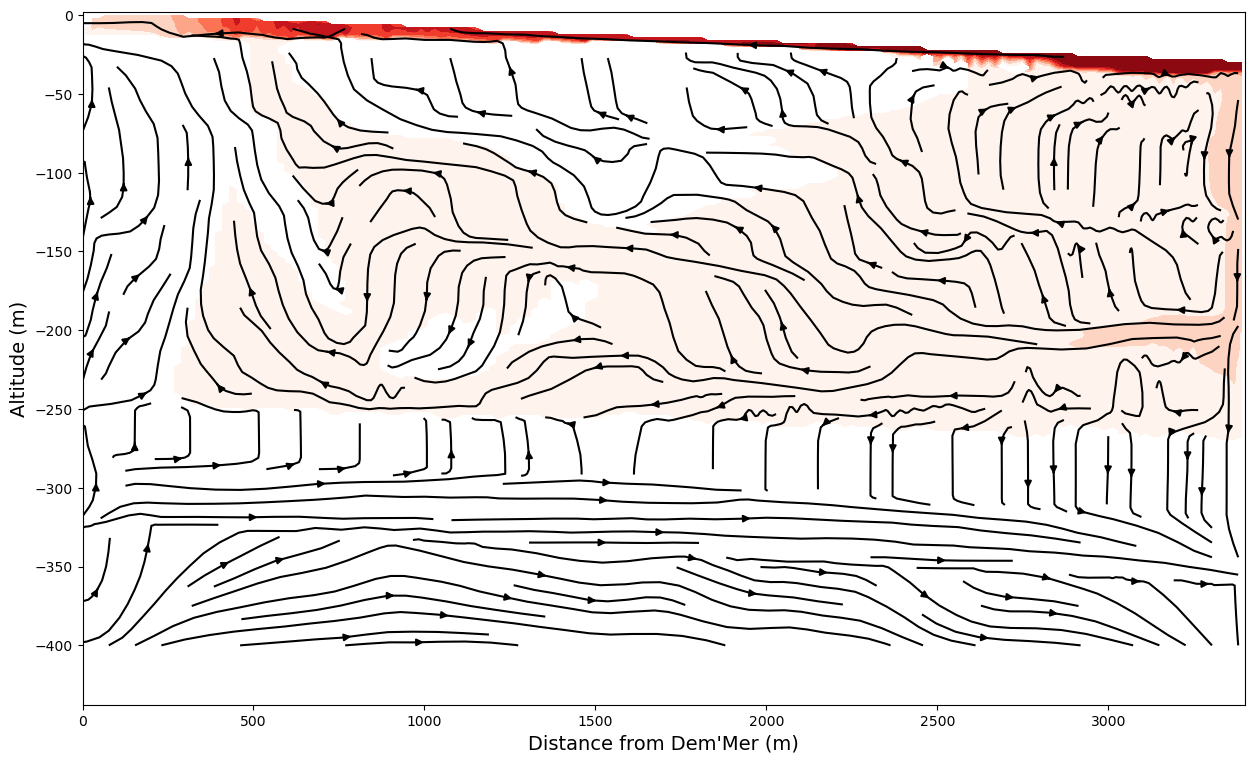

In [27]:
%matplotlib inline
i=199
figure, ax = plt.subplots(figsize=(15,9))

line=[(x0, 0), (x1, 0)]

xc = flopy.plot.PlotCrossSection(modelgrid=grid,line={"line": line})
plt.contourf(Xx-24100,Zz,Conc_p,vmin=2, vmax=35,cmap='Reds')
plt.xlabel("Distance from Dem'Mer (m)",fontsize=14)
plt.ylabel("Altitude (m)",fontsize=14)
#plt.colorbar(pc,location='bottom')
plt.streamplot(Xx-np.min(Xx),Zz,Qx_r,Qz_r,density=1.5,broken_streamlines=True,color='black')
plt.savefig('../Figs/concplot_he.png',dpi=300)

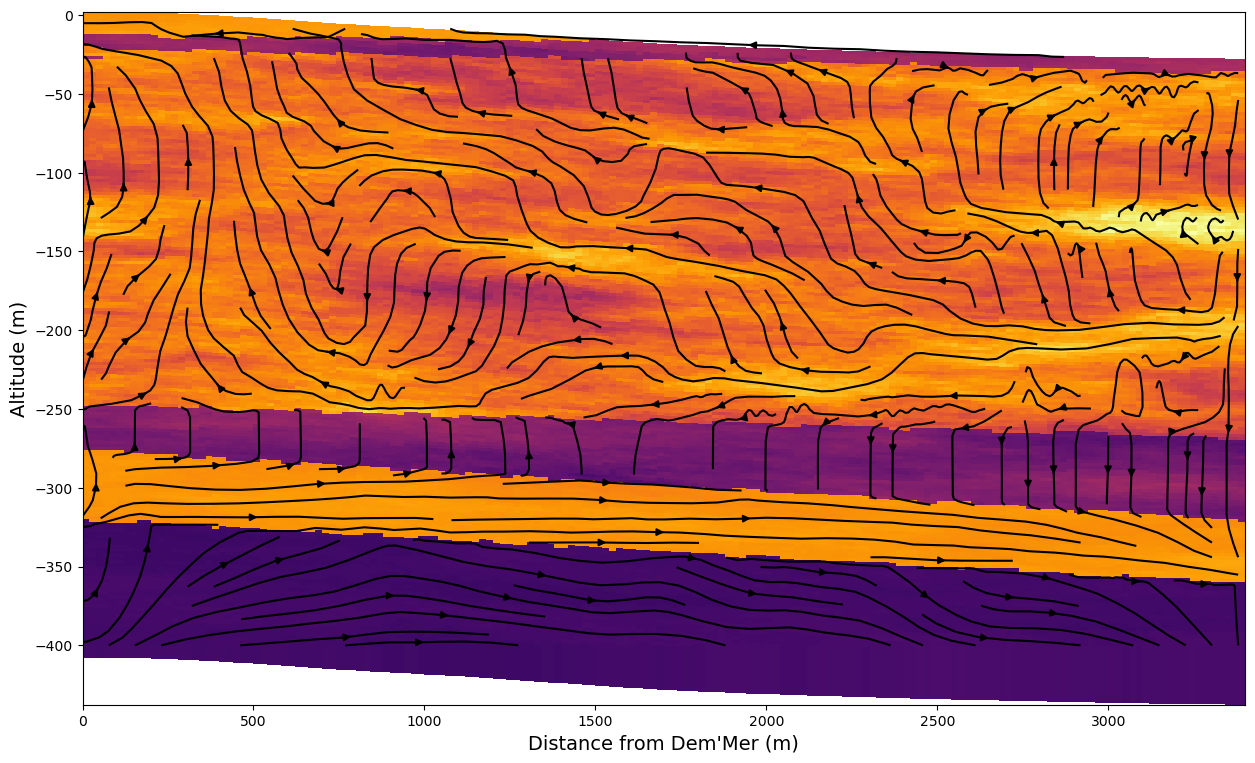

In [28]:
%matplotlib inline
i=199
figure, ax = plt.subplots(figsize=(15, 9))

line=[(x0, 0), (x1, 0)]

xc = flopy.plot.PlotCrossSection(modelgrid=grid,line={"line": line})
pc = xc.plot_array(np.log10(Ks[:,0,:]),cmap='inferno',vmin=-12)
#plt.colorbar(pc,location='bottom')
#ctr = xc.contour_array(Concs[i,:,0,:],colors='black',levels=np.linspace(2,34,4),alpha=.5)
plt.streamplot(Xx-np.min(Xx),Zz,Qx_r,Qz_r,density=1.5,broken_streamlines=True,color='black')
plt.xlabel("Distance from Dem'Mer (m)",fontsize=14)
plt.ylabel("Altitude (m)",fontsize=14)
#ctr.clabel(inline=True,fontsize=10)
plt.savefig('../Figs/streamplot_he.png',dpi=300)

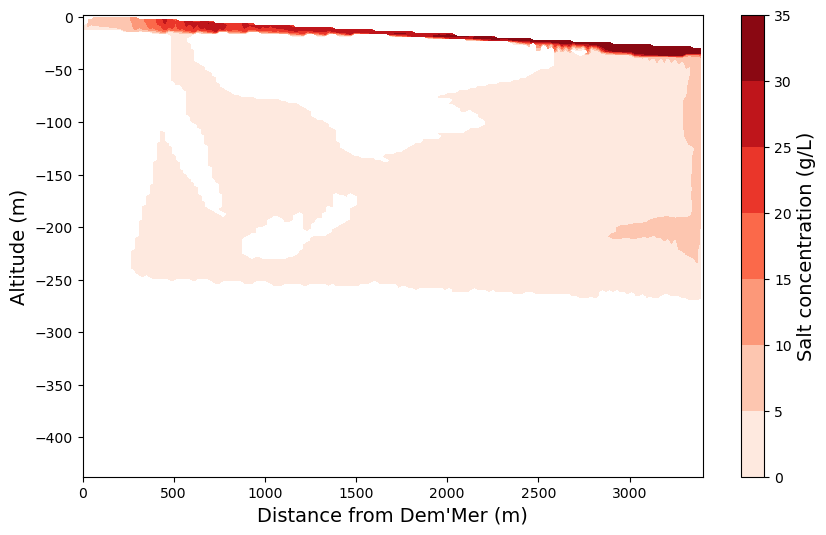

In [29]:
%matplotlib inline
i=199
figure, ax = plt.subplots(figsize=(10, 6))

line=[(x0, 0), (x1, 0)]

xc = flopy.plot.PlotCrossSection(modelgrid=grid,line={"line": line})
pc=plt.contourf(Xx-24100,Zz,Conc_p,vmin=2, vmax=35,cmap='Reds')
pc.set_clim(0,35)
plt.xlabel("Distance from Dem'Mer (m)",fontsize=14)
plt.ylabel("Altitude (m)",fontsize=14)
cb=plt.colorbar(pc,location='right',ticks=np.linspace(0,35,8))

cb.set_label(label='Salt concentration (g/L)',fontsize=14)
plt.savefig('C_cbar_right.png',dpi=300)

## Basses eaux

In [37]:
Xx,Zz,Qx_r,Qz_r,Conc=fr.read_pickle("../data/cross_section/res_be")

In [38]:
grid_x=grid.xcellcenters[0]
grid_z=np.linspace(z0,z1,nlay)

Xx,Zz=np.meshgrid(grid_x,grid_z)

posx=np.ravel(Xx)
posz=np.ravel(grid.zcellcenters[:,0,:])

pos=[(posx[i],posz[i]) for i in range(len(posx))]


Conc_p=griddata(pos, np.ravel(Conc), (Xx,Zz))
Conc_p[Conc_p<1]=np.nan

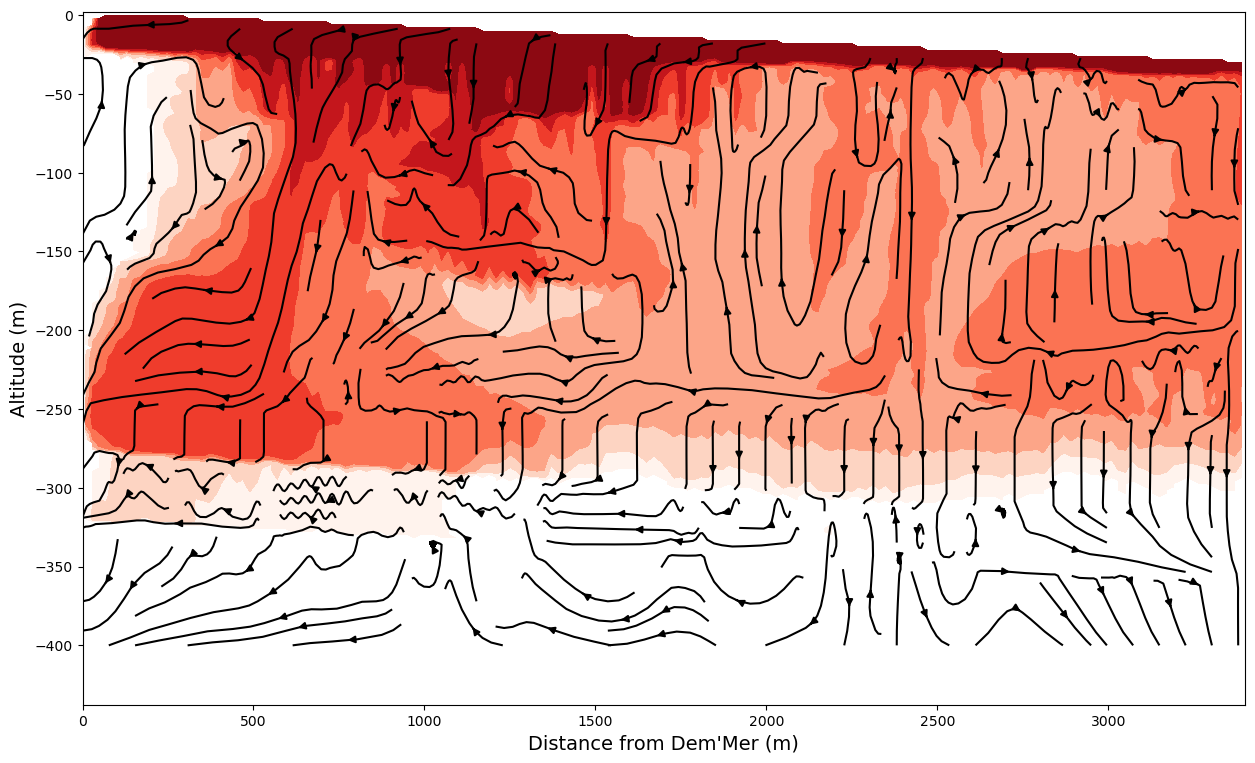

In [39]:
%matplotlib inline
i=199
figure, ax = plt.subplots(figsize=(15,9))

line=[(x0, 0), (x1, 0)]

xc = flopy.plot.PlotCrossSection(modelgrid=grid,line={"line": line})
plt.contourf(Xx-24100,Zz,Conc_p,vmin=2, vmax=35,cmap='Reds')
plt.xlabel("Distance from Dem'Mer (m)",fontsize=14)
plt.ylabel("Altitude (m)",fontsize=14)
#plt.colorbar(pc,location='bottom')
plt.streamplot(Xx-np.min(Xx),Zz,Qx_r,Qz_r,density=1.5,broken_streamlines=True,color='black')
plt.savefig('../Figs/concplot_be.png',dpi=300)

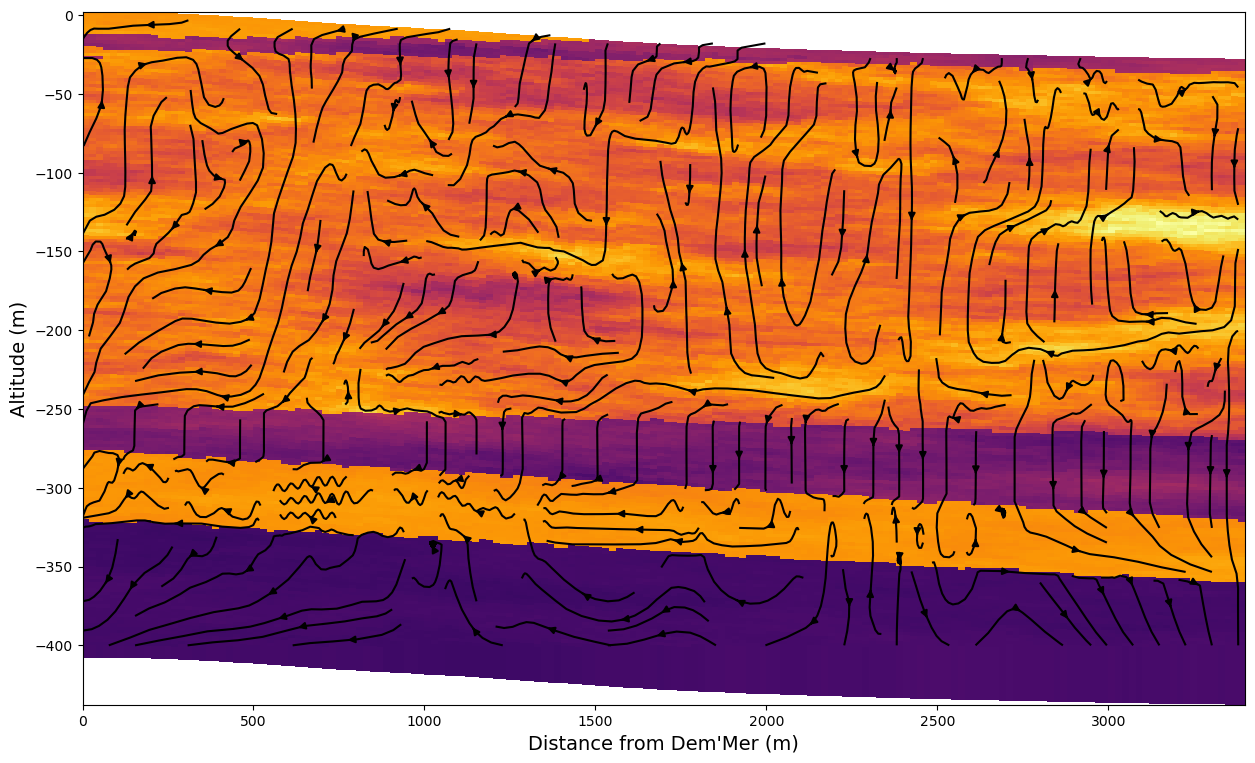

In [40]:
%matplotlib inline
i=199
figure, ax = plt.subplots(figsize=(15, 9))

line=[(x0, 0), (x1, 0)]

xc = flopy.plot.PlotCrossSection(modelgrid=grid,line={"line": line})
pc = xc.plot_array(np.log10(Ks[:,0,:]),cmap='inferno',vmin=-12)
#plt.colorbar(pc,location='bottom')
#ctr = xc.contour_array(Concs[i,:,0,:],colors='black',levels=np.linspace(2,34,4),alpha=.5)
plt.streamplot(Xx-np.min(Xx),Zz,Qx_r,Qz_r,density=1.5,broken_streamlines=True,color='black')
plt.xlabel("Distance from Dem'Mer (m)",fontsize=14)
plt.ylabel("Altitude (m)",fontsize=14)
#ctr.clabel(inline=True,fontsize=10)
plt.savefig('../Figs/streamplot_be.png',dpi=300)